**NOTE: This notebook is written for the Google Colab platform. However it can also be run (possibly with minor modifications) as a standard Jupyter notebook.** 



In [ ]:
#@title -- Installation of Packages -- { display-mode: "form" }
import sys
!{sys.executable} -m pip install git+https://github.com/michalgregor/gym_plannable.git
!{sys.executable} -m pip install git+https://github.com/michalgregor/rl_tabular.git

In [ ]:
#@title -- Import of Necessary Packages -- { display-mode: "form" }
%matplotlib inline
from gym_plannable.env import CliffWalkerEnv
import numpy as np
from rl_tabular import Trainer, seed
from rl_tabular import ActionValueTable
from rl_tabular.maze_env_plots import Plotter
from rl_tabular import EpsGreedyPolicy
from rl_tabular import qtable_control
from rl_tabular import QLearning, SARSA
from rl_tabular import ExponentialSchedule

In [ ]:
#@title -- Auxiliary Functions -- { display-mode: "form" }

class RewardLogger:
    def __init__(self):
        self.episodic_rewards = []
        self._running_reward = 0
        
    def __call__(self, step, train_info):
        self._running_reward += train_info.transition[2]
        done = train_info.transition[4]
        
        if done:
            self.episodic_rewards.append(self._running_reward)
            self._running_reward = 0

## Q-Learning vs. SARSA

In this notebook we are going to have a look at the differences between two TD methods: **Q-learning**  (an **off-policy method** ) and **SARSA**  (an **on-policy method** ).

### The Cliff-Walker Environment

Our experiments will be done in the cliff walker environment, which is illustrated in the figure below.

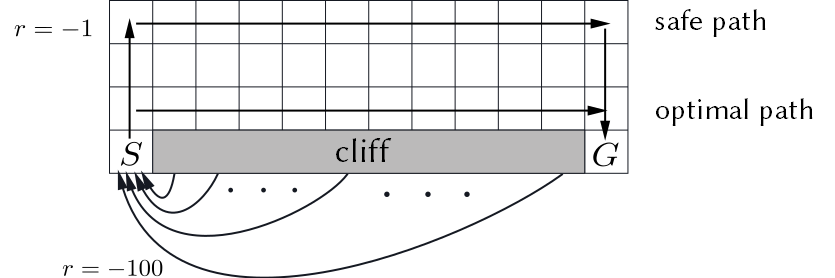

In this environment the goal of the agent is to get from the start state to the goal state as quickly as possible. Unless anything else happens, the agent receives the reward of -1 at every time step. Once the agent gets to the goal state, the episode ends (total rewards stop decreasing).

However, there is a cliff right next to the optimal path to the goal state. If the agent steps onto the cliff, the agent receives the reward of -100 and the episode ends.

### Simple Q-Learning

Let us first apply simple Q-learning without a replay buffer and with a constant exploration rate $\varepsilon = 0.1$.

Recall that under Q-learning we compute the temporal difference as:

$$
\delta = r_{t+1} + \gamma \underset{a}{\max} \ Q(s_{t+1}, a)-Q(s_{t},a_{t})
$$
In this tiny environment, the agent should be able to discover the optimal policy soon.



In [ ]:
seed(1)

env = CliffWalkerEnv(
    show_path=True,
    show_path_kw=dict(show_arrows=False, show_visited=True)
)

plotter = Plotter(env, ActionValueTable, render_agent=False)
reward_logger = RewardLogger()

qtable = ActionValueTable(env.action_space.n)
algo = QLearning(qtable, alpha=0.5, gamma=0.9)
policy = EpsGreedyPolicy(qtable, env.action_space.n, epsilon=0.1)

trainer = Trainer(
    algo, policy, verbose=10,
    on_end_step=[reward_logger],
    on_end_episode=[lambda *args: plotter.plot(qtable)]
)

trainer.train(env, max_episodes=100, max_episode_steps=1000)
print(f"\nThe mean episodic rewards during training: {np.mean(reward_logger.episodic_rewards)}")

In [ ]:
env = CliffWalkerEnv(show_path=True)
qtable_control(env, qtable, max_steps=100)
env.render()

### Simple SARSA

Next, let us apply SARSA under the same conditions. Recall that the SARSA update is different in that it updates based on an action that the policy would actually take and not the max-Q action:

$$
\delta = r_{t+1} + \gamma \ Q(s_{t+1}, a_{t+1})-Q(s_{t},a_{t})
$$
Now, the actual policy being followed is the $\varepsilon$-greedy policy, which sometimes takes random actions. Under such policy, it is not exactly safe to walk right alongside the cliff, because the agent might decide randomly at any point that it is going to jump off the cliff. SARSA, being on-policy, takes this into account. It is, therefore, going to learn to move further away from the cliff – a path, where the agent is less likely to jumping off the cliff.

This is why the mean episodic rewards accumulated by SARSA during learning, will be greater than those accumulated by Q learning: the SARSA agent will be less likely to jump off the cliff while following the $0.1$-greedy policy.



In [ ]:
seed(1)

env = CliffWalkerEnv(
    show_path=True,
    show_path_kw=dict(show_arrows=False, show_visited=True)
)

plotter = Plotter(env, ActionValueTable, render_agent=False)
reward_logger = RewardLogger()

qtable = ActionValueTable(env.action_space.n)
policy = EpsGreedyPolicy(qtable, env.action_space.n, epsilon=0.1)
algo = SARSA(qtable, policy=policy, alpha=0.5, gamma=0.9)

trainer = Trainer(
    algo, policy, verbose=10,
    on_end_step=[reward_logger],
    on_end_episode=[lambda *args: plotter.plot(qtable)]
)

trainer.train(env, max_episodes=100, max_episode_steps=1000)
print(f"\nThe mean episodic rewards during training: {np.mean(reward_logger.episodic_rewards)}")

In [ ]:
env = CliffWalkerEnv(show_path=True)
qtable_control(env, qtable, max_steps=100)
env.render()

Okay, so **Q-learning**  learns the **optimal value function** : once we make the policy greedy ($\varepsilon = 0$), the agent is going to behave optimally.

**SARSA** , on the other hand, **assumes that we will continue to follow the $0.1$-greedy policy**  and optimizes for that scenario.

So once we are done learning, Q-learning achieves greater rewards because it chooses the optimal path, whereas SARSA keeps following the safe path even though it is no longer necessary.

### Annealing the Exploration Rate for SARSA

Naturally, at the end of the day, what we usually really care about is learning the optimal policy. The good news is that **SARSA can also learn the optimal policy**  if we anneal the exploration rate so that the policy SARSA is learning about gradually approaches the greedy policy.

We already know how to form an exponential schedule so let us create one, where the final value of $\varepsilon$ is going to be very low, e.g. `1e-15`.



In [ ]:
seed(1)

env = CliffWalkerEnv(
    show_path=True,
    show_path_kw=dict(show_arrows=False, show_visited=True)
)

plotter = Plotter(env, ActionValueTable, render_agent=False)
reward_logger = RewardLogger()

qtable = ActionValueTable(env.action_space.n)
policy = EpsGreedyPolicy(qtable, env.action_space.n)
algo = SARSA(qtable, policy=policy, alpha=0.5, gamma=0.9)

eps_schedule = ExponentialSchedule(
    policy.set_epsilon,
    init_val=1.0, final_val=1e-15,
    first_step=5, final_step=100,
    method='episode'
)

trainer = Trainer(
    algo, policy, verbose=10,
    on_begin_step=[eps_schedule],
    on_end_step=[reward_logger],
    on_end_episode=[lambda *args: plotter.plot(qtable)]
)

trainer.train(env, max_episodes=100, max_episode_steps=1000)
print(f"\nThe mean episodic rewards during training: {np.mean(reward_logger.episodic_rewards)}")

In [ ]:
env = CliffWalkerEnv(show_path=True)
qtable_control(env, qtable, max_steps=100)
env.render()

---
### Task 1: Comparing against Q-Learning with Annealing

**In the cell below, rerun the same experiment, but now with Q-Learning and the exponential schedule. What are the mean episodic rewards during training? How do they compare to those of SARSA?** 

---


In [ ]:
seed(1)

env = CliffWalkerEnv(
    show_path=True,
    show_path_kw=dict(show_arrows=False, show_visited=True)
)

plotter = Plotter(env, ActionValueTable, render_agent=False)
reward_logger = RewardLogger()


                  
# ---
                  

